# Implementasi _Convex Hull_ untuk Visualisasi Tes _Linear Separability Dataset_ dengan Algoritma _Divide and Conquer_
## Gede Prasidha Bhawarnawa - 13520004 - K01

### Library yang Digunakan untuk Membuat Convex Hull
**Jalankan dua balok kode di bawah sebelum menjalankan balok kode lainnya!**

In [72]:
import matplotlib.pyplot as plt
import math
from scipy.spatial import ConvexHull
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
# Pembuatan class Coordinates untuk menyimpan nilai X dan Y suatu titik
class Coordinates:
    def __init__(self, x, y):
        self.x = x
        self.y = y

# Mengurutkan semua koordinat berdasarkan kenaikan absisnya. Bila ada dua titik dengan absis yang sama, diurutkan berdasarkan kenaikan absisnya.
# sorting dilakukan dengan menggunakan selection sort (diimplementasikan dengan dasar algoritma Bubble Sort)
def sortList(CoordinatesList):
    # snippet code ini berfungsi untuk mengurutkan semua CoordinatesList berdasarkan kenaikan absisnya
    # terdapat kemungkinan urutan ordinat belum tepat
    for i in range(0, len(CoordinatesList)):
        toBeSwitchedIndex = i
        for j in range(i+1, len(CoordinatesList)):
            if CoordinatesList[j].x < CoordinatesList[toBeSwitchedIndex].x:
                toBeSwitchedIndex = j
        CoordinatesList[i], CoordinatesList[toBeSwitchedIndex] = CoordinatesList[toBeSwitchedIndex], CoordinatesList[i]
    # snippet ccode ini berfungsi untuk mengurutkan CoordinatesList yang sudah terurut berdasarkan kenaikan nilai absisnya
    #   sesuai dengan kenaikan nilai ordinatnya bila ditemukan dua titik dengan absis yang sama
    #   loop diulangi sampai tidak ada proses swap
    isNotSorted = True
    while isNotSorted:
        swapCount = 0
        for i in range(0, len(CoordinatesList) - 1):
            if ((CoordinatesList[i].x == CoordinatesList[i+1].x) and (CoordinatesList[i].y > CoordinatesList[i + 1].y)):
                swapCount += 1
                CoordinatesList[i], CoordinatesList[i + 1] = CoordinatesList[i + 1], CoordinatesList[i]
        if swapCount == 0:
            isNotSorted = False
    return CoordinatesList

# Membagi semua titik yang tersisa menjadi dua bagian, LeftCoordinatesList dan RightCoordinatesList, berdasarkan nilai determinannya
# Determinan > 0 : Titik berada pada atas/kiri pembatas, masuk ke dalam list LeftCoordinatesList
# Determinan = 0 : Titik berada pada pembatas, diabaikan
# Determinan < 0 : Titik berada pada bawah/kanan pembatas, masuk ke dalam list RightCoordinatesList
def splitByDeterminant(start, end, CoordinatesList, LeftCoordinatesList, RightCoordinatesList):
    while (len(CoordinatesList) > 0):
        var = CoordinatesList[0]
        value = determinant(start, var, end)
        if value < 0: 
            CoordinatesList.pop(0)
            RightCoordinatesList.append(var)
        elif value > 0:
            CoordinatesList.pop(0)
            LeftCoordinatesList.append(var)
        else:
            CoordinatesList.pop(0)
    return LeftCoordinatesList, RightCoordinatesList

# Mengembalikan nilai determinan untuk menentukan posisi sebuah titik di atas, di bawah, atau pada garis start-end
# Terdapat kasus error handling bila menerima input yang None pada start, var, atau end
def determinant(start, var, end):
    if start is None or var is None or end is None:
        return 0
    else:
        value = start.x * end.y + var.x * start.y + end.x * var.y - var.x * end.y - end.x * start.y - start.x * var.y
        return value 

# Menghitung sudut yang dibentuk oleh 3 titik dengan var sebagai titik acuan perhitungan
# Terdapat error handling bila ditemukan hasil dotProduct di luar range [-1, 1], yaitu 90 derajat karena cos(90) = Nan
def measureAngle(start, var, end):
    startToVar = [var.x - start.x, var.y - start.y]
    varToEnd = [end.x - var.x, end.y - var.y]
    dotProduct = np.dot(startToVar, varToEnd)
    if not(abs(dotProduct) > 1):
        tempAngle = np.arccos(dotProduct)
    else:
        tempAngle = 90
    return tempAngle

# Menghitung jumlah titik yang berada di luar garis antara titik start dan end (mengembalikan integer).
# Digunakan sebagai uji syarat rekursif
def isThereOuterConvexEdge(start, end, CoordinatesList, upperConvexHull):
    count = 0
    for var in CoordinatesList:
        if var is not None:
            value = determinant(start, var, end)
            if (upperConvexHull):
                if (value > 0):
                    count += 1
            else:
                if (value < 0):
                    count += 1
    return count

# Untuk menguji sebuah titik berada di dalam atau di luar garis (mengembalikan boolean)
def isOutsideInsideLine(start, var, end, isOutside):
    if isOutside:
        return (determinant(start, var, end) > 0)
    else:
        return (determinant(start, var, end) < 0)

# Mencari list Coordinates yang membangun Convex Hull bagian atas dan bawah
# Dasar Rekursi (Base Case) : Tidak ada titik terjauh dan terluar (ujung Convex Hull) diantara titik awal dan akhir. Mengembalikan set list Coordinates (awal + akhir)
# Fungsi Rekursi : Mencari titik terjauh dan terluar dan menjadikannya sebagai titik akhir baru saat memanggil fungsi rekursi lagi
def recursiveConvexHull(origin, startList, tempList, endList, isUpper):
    countFinish = isThereOuterConvexEdge(startList[-1], endList[0], origin, isUpper)
    # Fungsi rekursi
    if countFinish != 0:
        maxDistanceFromStartEnd = -1
        maxAngleFromStartEnd = -1
        maxPoint = None
        # s = start, e = end, m = gradien, c = constant
        # membuat garis dengan rumus y = mx + c
        s = startList[-1]
        if (len(tempList) == 0):
            e = endList[0]
        else:
            e = tempList[0]
        m = (e.y - s.y) / (e.x - s.x)
        c = s.y - m * s.x
        for var in origin:
            if (var not in startList) and (var not in endList) and (var not in tempList) and (isOutsideInsideLine(s, var, e, isUpper)):
                tempDistanceFromStartEnd = abs((m * var.x - var.y + c) / math.sqrt(m ** 2 + 1))
                if (tempDistanceFromStartEnd > maxDistanceFromStartEnd):
                    tempAngle = measureAngle(s,var,e)
                    maxDistanceFromStartEnd = tempDistanceFromStartEnd
                    maxAngleFromStartEnd = tempAngle
                    maxPoint = var
                elif (tempDistanceFromStartEnd == maxDistanceFromStartEnd):
                    tempAngle = measureAngle(s,var,e)
                    if (tempAngle > maxAngleFromStartEnd):
                        maxAngleFromStartEnd = tempAngle
                        maxPoint = var 
        tempList.insert(0,maxPoint)
        # untuk mengecek apakah ada titik di antara titik maks sebelumnya dengan titik awal yang merupakan convex edge
        count = 999
        if maxPoint is not None:
            count = isThereOuterConvexEdge(s, maxPoint, origin, isUpper)
        # Error Handling untuk kasus elemen maxPoint adalah None
        if count == 0 or maxPoint is None:
            newStartList = startList + tempList
            return recursiveConvexHull(origin, newStartList, [], endList, isUpper)
        else:
            return recursiveConvexHull(origin, startList, [maxPoint], endList, isUpper)
    # Basis rekursi
    else:
        return startList + endList

# Mengubah CoordinatesList menjadi sebuah 2D list untuk diplot oleh matplotlib
def createListForPlot(CoordinatesList):
    listX = []
    listY = []
    for i in range(len(CoordinatesList)):
        if CoordinatesList[i] != None:
            listX.append(CoordinatesList[i].x)
            listY.append(CoordinatesList[i].y)
    listCombine = [listX, listY]
    return listCombine

# Fungsi utama (main)
def myConvexHull(bucket):
    CoordinatesList = []
    LeftCoordinatesList = []
    RightCoordinatesList = []
    ConvexEdgesList = []
    for i in range(0, len(bucket)):
        CoordinatesList.append(Coordinates(bucket[i,0], bucket[i,1]))
    CoordinatesList = sortList(CoordinatesList)
    # Menyimpan titik p1(x1,y1)
    startEdge = CoordinatesList[0]
    # Menyimpan titik pn(xn,yn)
    endEdge = CoordinatesList[-1]
    # Bagi sisa titik berdasarkan nilai determinan
    copyCoordinatesList = CoordinatesList[:]
    LeftCoordinatesList, RightCoordinatesList = splitByDeterminant(startEdge, endEdge, copyCoordinatesList[1:-1], LeftCoordinatesList, RightCoordinatesList)
    LeftCoordinatesList = sortList(LeftCoordinatesList)
    RightCoordinatesList = sortList(RightCoordinatesList)
    upLeftConvexEdges = recursiveConvexHull(LeftCoordinatesList, [startEdge], [], [endEdge], True)
    downRightConvexEdges = recursiveConvexHull(RightCoordinatesList, [startEdge], [], [endEdge], False)
    return upLeftConvexEdges, downRightConvexEdges, CoordinatesList
    

### Convex Hull sklearn.datasets.load_iris()
Terdapat dua balok kode di bawah sebagai source code untuk menghasilkan Convex Hull menggunakan library myConvexHull dan scipy.spatial.ConvexHull pada sklearn.datasets.load_iris()
Akan diminta input oleh program untuk mengembalikan convex hull dengan parameter yang berbeda.
Kedua balok disediakan agar dapat dibandingkan antara library buatan penulis dan library milik scipy.


Jenis Convex Hull yang ingin dihasilkan dari sklearn.datasets.load_iris() menggunakan myConvexHull: 
1. Sepal Length vs Sepal Width
2. Petal Length vs Petal Width


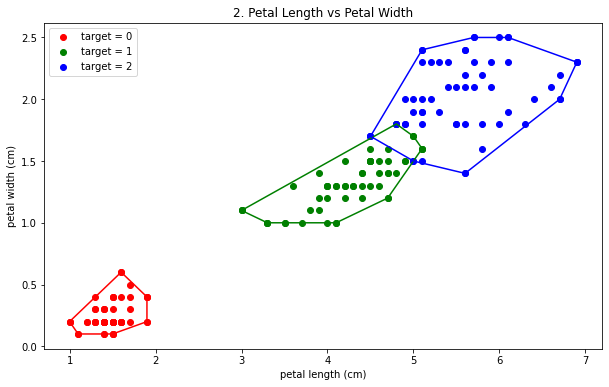

In [112]:
title1 = "1. Sepal Length vs Sepal Width"
title2 = "2. Petal Length vs Petal Width"
chosenTitle = ""
column1 = 0
column2 = 1
print("Jenis Convex Hull yang ingin dihasilkan dari sklearn.datasets.load_iris() menggunakan myConvexHull: ")
print(title1)
print(title2)
isValidated = False
while not isValidated:
    query = int(input("Masukkan angka sesuai jenis Convex Hull yang ingin dihasilkan : "))
    if query == 1:
        chosenTitle = title1
        column1 = 0
        column2 = 1
        isValidated = True
    elif query == 2:
        chosenTitle = title2
        column1 = 2
        column2 = 3
        isValidated = True

fig, ax = plt.subplots(figsize = (10, 6))
colors = ['r', 'g', 'b']

ax.set_title(chosenTitle)

data = datasets.load_iris()
df = pd.DataFrame(data.data, columns = data.feature_names)
df['Target'] = pd.DataFrame(data.target)

ax.set_xlabel(data.feature_names[column1])
ax.set_ylabel(data.feature_names[column2])

for i in range(len(data.target_names)):
    legend = "target = " + str(i)
    bucket = df[df['Target'] == i].iloc[:, [column1, column2]].values
    up, down, all = myConvexHull(bucket)
    hullDown = createListForPlot(down)
    ax.scatter(hullDown[0], hullDown[1], color = colors[i])
    ax.plot(hullDown[0], hullDown[1], color = colors[i])
    hullUp = createListForPlot(up)
    ax.scatter(hullUp[0], hullUp[1], color = colors[i])
    ax.plot(hullUp[0], hullUp[1], color = colors[i])
    listAll = createListForPlot(all)
    ax.scatter(listAll[0], listAll[1], color = colors[i], label = legend)
    ax.legend()
plt.show()

Jenis Convex Hull yang ingin dihasilkan dari sklearn.datasets.load_iris() menggunakan scipy.spatial.ConvexHull: 
1. Sepal Length vs Sepal Width
2. Petal Length vs Petal Width


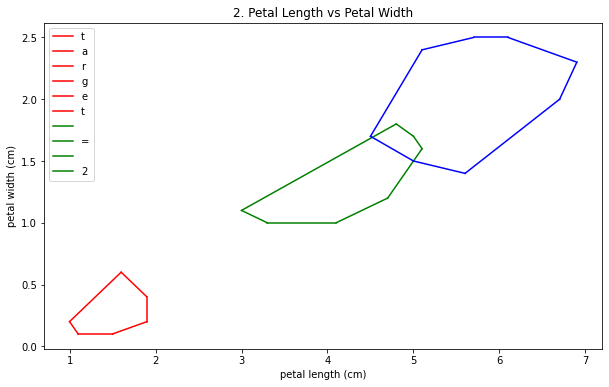

In [115]:
title1 = "1. Sepal Length vs Sepal Width"
title2 = "2. Petal Length vs Petal Width"
chosenTitle = ""
column1 = 0
column2 = 1
print("Jenis Convex Hull yang ingin dihasilkan dari sklearn.datasets.load_iris() menggunakan scipy.spatial.ConvexHull: ")
print(title1)
print(title2)
isValidated = False
while not isValidated:
    query = int(input("Masukkan angka sesuai jenis Convex Hull yang ingin dihasilkan : "))
    if query == 1:
        chosenTitle = title1
        column1 = 0
        column2 = 1
        isValidated = True
    elif query == 2:
        chosenTitle = title2
        column1 = 2
        column2 = 3
        isValidated = True

plt.figure(figsize = (10, 6))
colors = ['r', 'g', 'b']

plt.title(chosenTitle)

data = datasets.load_iris()
df = pd.DataFrame(data.data, columns = data.feature_names)
df['Target'] = pd.DataFrame(data.target)

plt.xlabel(data.feature_names[column1])
plt.ylabel(data.feature_names[column2])

for i in range(len(data.target_names)):
    bucket = df[df['Target'] == i].iloc[:, [column1, column2]].values
    hull = ConvexHull(bucket)
    for simplex in hull.simplices:
        plt.plot(bucket[simplex, 0], bucket[simplex, 1], colors[i])
plt.show()

### Convex Hull sklearn.datasets.load_wine()
Terdapat dua balok kode di bawah sebagai source code untuk menghasilkan Convex Hull menggunakan library myConvexHull dan scipy.spatial.ConvexHull pada sklearn.datasets.load_wine()
Akan diminta input oleh program untuk mengembalikan convex hull dengan parameter yang berbeda.
Kedua balok disediakan agar dapat dibandingkan antara library buatan penulis dan library milik scipy.

Jenis Convex Hull yang ingin dihasilkan dari sklearn.datasets.load_iris() menggunakan myConvexHull: 
1. Alcohol vs Malic Acid
2. Ash vs Alcalinity of Ash
3. Flavanoids vs Nonflavanoids Phenols
4. Color Intensity vs Hue


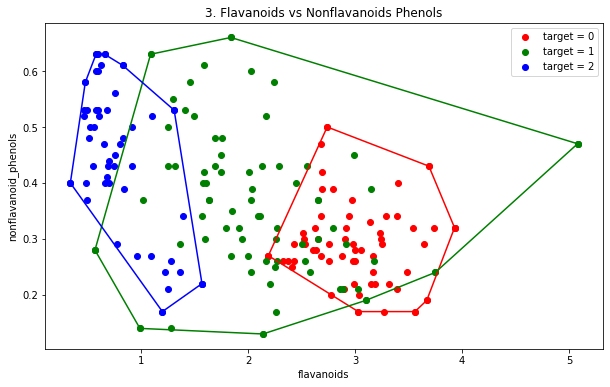

In [110]:
title1 = "1. Alcohol vs Malic Acid"
title2 = "2. Ash vs Alcalinity of Ash"
title3 = "3. Flavanoids vs Nonflavanoids Phenols"
title4 = "4. Color Intensity vs Hue"
chosenTitle = ""
column1 = 0
column2 = 1
print("Jenis Convex Hull yang ingin dihasilkan dari sklearn.datasets.load_iris() menggunakan myConvexHull: ")
print(title1)
print(title2)
print(title3)
print(title4)
isValidated = False
while not isValidated:
    query = int(input("Masukkan angka sesuai jenis Convex Hull yang ingin dihasilkan : "))
    if query == 1:
        chosenTitle = title1
        column1 = 0
        column2 = 1
        isValidated = True
    elif query == 2:
        chosenTitle = title2
        column1 = 2
        column2 = 3
        isValidated = True
    elif query == 3:
        chosenTitle = title3
        column1 = 6
        column2 = 7
        isValidated = True
    elif query == 4:
        chosenTitle = title4
        column1 = 9
        column2 = 10
        isValidated = True

fig, ax = plt.subplots(figsize = (10, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

ax.set_title(chosenTitle)

data = datasets.load_wine(as_frame=True)
df = pd.DataFrame(data.data, columns = data.feature_names)
df['Target'] = pd.DataFrame(data.target)

ax.set_xlabel(data.feature_names[column1])
ax.set_ylabel(data.feature_names[column2])

for i in range(len(data.target_names)):
    legend = "target = " + str(i)
    bucket = df[df['Target'] == i].iloc[:, [column1, column2]].values
    up, down, all = myConvexHull(bucket)
    hullDown = createListForPlot(down)
    ax.scatter(hullDown[0], hullDown[1], color = colors[i])
    ax.plot(hullDown[0], hullDown[1], color = colors[i])
    hullUp = createListForPlot(up)
    ax.scatter(hullUp[0], hullUp[1], color = colors[i])
    ax.plot(hullUp[0], hullUp[1], color = colors[i])
    listAll = createListForPlot(all)
    ax.scatter(listAll[0], listAll[1], color = colors[i], label = legend)
    ax.legend()
plt.show()

Jenis Convex Hull yang ingin dihasilkan dari sklearn.datasets.load_iris(): 
1. Alcohol vs Malic Acid
2. Ash vs Alcalinity of Ash
3. Flavanoids vs Nonflavanoids Phenols
4. Color Intensity vs Hue


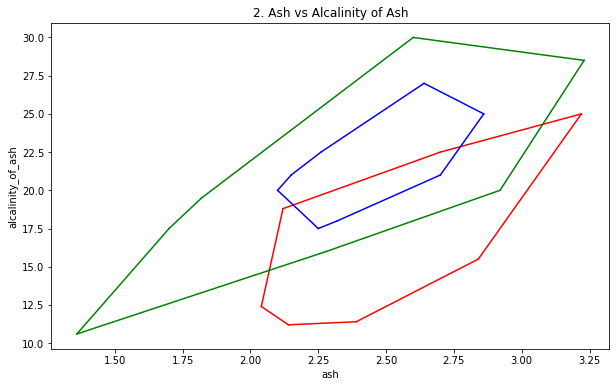

In [101]:
title1 = "1. Alcohol vs Malic Acid"
title2 = "2. Ash vs Alcalinity of Ash"
title3 = "3. Flavanoids vs Nonflavanoids Phenols"
title4 = "4. Color Intensity vs Hue"
chosenTitle = ""
column1 = 0
column2 = 1
print("Jenis Convex Hull yang ingin dihasilkan dari sklearn.datasets.load_iris() menggunakan scipy.spatial.ConvexHull: ")
print(title1)
print(title2)
print(title3)
print(title4)
isValidated = False
while not isValidated:
    query = int(input("Masukkan angka sesuai jenis Convex Hull yang ingin dihasilkan : "))
    if query == 1:
        chosenTitle = title1
        column1 = 0
        column2 = 1
        isValidated = True
    elif query == 2:
        chosenTitle = title2
        column1 = 2
        column2 = 3
        isValidated = True
    elif query == 3:
        chosenTitle = title3
        column1 = 6
        column2 = 7
        isValidated = True
    elif query == 4:
        chosenTitle = title4
        column1 = 9
        column2 = 10
        isValidated = True

plt.figure(figsize = (10, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

plt.title(chosenTitle)

data = datasets.load_wine(as_frame=True)
df = pd.DataFrame(data.data, columns = data.feature_names)
df['Target'] = pd.DataFrame(data.target)

plt.xlabel(data.feature_names[column1])
plt.ylabel(data.feature_names[column2])

for i in range(len(data.target_names)):
    bucket = df[df['Target'] == i].iloc[:, [column1, column2]].values
    hull = ConvexHull(bucket)
    for simplex in hull.simplices:
        plt.plot(bucket[simplex, 0], bucket[simplex, 1], colors[i])
plt.show()